In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Subset
import pickle
import os
import torch.nn.functional as F
from torch_ema import ExponentialMovingAverage as EMA
from types import SimpleNamespace
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import sys
sys.path.insert(0, os.getcwd())
from PRJ_AUTO_NOISEPARAM.code.lib.diff_model_utils import *
from PRJ_AUTO_NOISEPARAM.code.lib.utils import *

### Define the Parameters, Model Architecture and Load the Saved Model

In [3]:
config = {
'chn_multiples': {
    'values': [1, 1, 2]
    },
'ch_res': {
        'values': 64
    },
'num_res_blocks': {
        'values': 1
    }
}

model = Scaled(Unet)(in_dim=128, in_ch=1, out_ch=1, 
                        ch_mult=tuple(config['chn_multiples']['values']),           
                        num_res_blocks=config['num_res_blocks']['values'],          
                        ch=config['ch_res']['values'],                               
                        attn_resolutions=(14,)).to("cuda")
schedule = ScheduleLogLinear(N=100, sigma_min=0.1, sigma_max=10)

model.load_state_dict(torch.load("PRJ_AUTO_NOISEPARAM/models/diffusion_unet_attn.pth", map_location=torch.device("cuda")))

<All keys matched successfully>

### Call the Sampling Algorithm to Generate Data and Plot

In [40]:
model.eval()
*xts, x0 = samples(model.to("cuda"), 
                    schedule.sample_sigmas(20),
                    gam=torch.tensor([2]).to("cuda"))

print(x0.shape)
results_x0 = x0.squeeze(0).squeeze(0).cpu().numpy()
results_x0.shape

torch.Size([1, 1, 128, 128])


(128, 128)

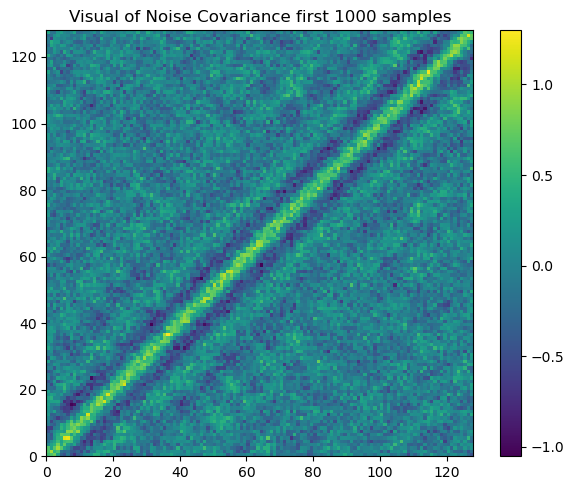

In [41]:
plt.figure(1, figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.title('Visual of Noise Covariance first 1000 samples')
plt.pcolormesh(results_x0)
plt.colorbar()

plt.tight_layout()
plt.show()

### Upsample the Data to Original Dimension

torch.Size([1, 1, 128, 128])
torch.Size([1000, 1000])


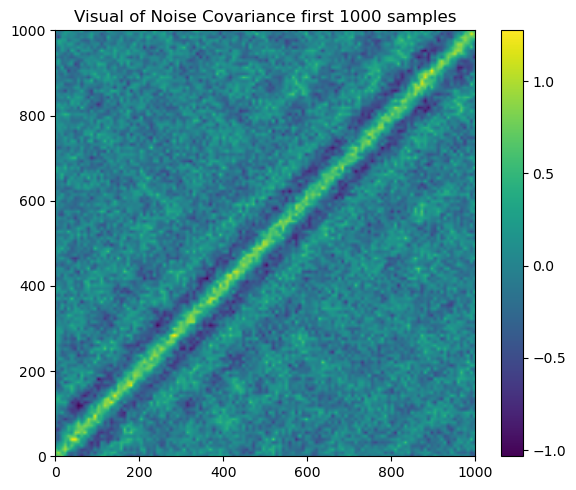

In [42]:
data_resized = x0
print(data_resized.shape)
data_upsampled = F.interpolate(data_resized, size=(1000, 1000), mode='bilinear', align_corners=True)
data_upsampled = data_upsampled.squeeze(0).squeeze(0)  # Remove batch and channel dims
print(data_upsampled.shape)


plt.figure(1, figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.title('Visual of Noise Covariance first 1000 samples')
plt.pcolormesh(data_upsampled.cpu().numpy())
plt.colorbar()

plt.tight_layout()
plt.show()

### Add Gaussian Blur to Smooth The Image

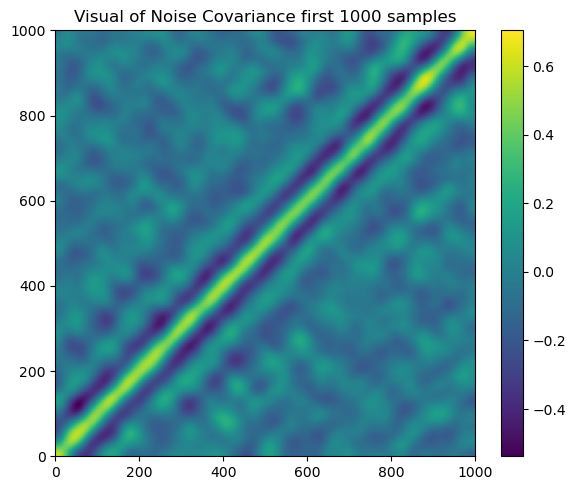

In [43]:
from torchvision.transforms import GaussianBlur

smoothing_kernel_size = 49  # Define kernel size for smoothing
data_smoothed = GaussianBlur(kernel_size=smoothing_kernel_size, sigma=(11, 19))(data_upsampled.unsqueeze(0).unsqueeze(0))
data_smoothed = data_smoothed.squeeze(0).squeeze(0)  # Remove batch and channel dims

plt.figure(1, figsize=(6, 5))

plt.subplot(1, 1, 1)
plt.title('Visual of Noise Covariance first 1000 samples')
plt.pcolormesh(data_smoothed.cpu().numpy())
plt.colorbar()

plt.tight_layout()
plt.show()

## Visually Compare Results aginst original covariance matrix and Noise Param Type 3

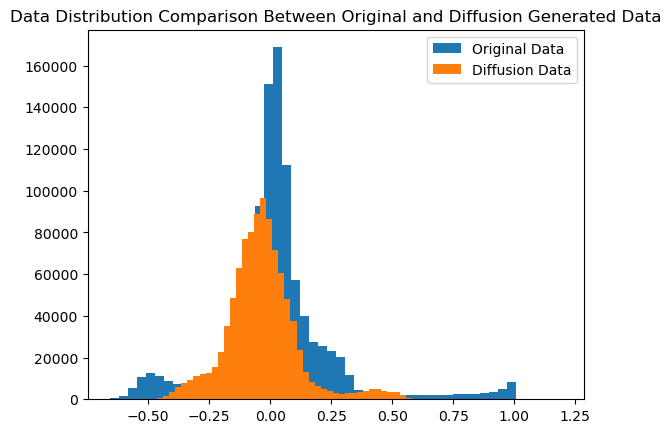

In [44]:
rawdatapath = 'PRJ_AUTO_NOISEPARAM/data/raw/ANMO/*'
procsavepath = 'PRJ_AUTO_NOISEPARAM/data/processed/ANMO'
procsavepathfile = os.path.join(procsavepath, 'anmo_noise_data_normalized.pkl')

if os.path.isfile(procsavepathfile) == 1:
    with open(procsavepathfile, 'rb') as f:
        trainset = pickle.load(f)
else:
    print("no data loaded")
trainsubset = Subset(trainset, range(len(trainset)))
dataloader = DataLoader(trainsubset, batch_size=5000, shuffle=False)


data = next(iter(dataloader))
data = data[:,:1000]
data = data.T@data
for i in range(0,len(data)):
                data[i] = data[i]/data[i,i]


plt.hist(data.flatten().numpy(), label="Original Data", bins=50)
plt.hist(data_smoothed.cpu().numpy().flatten(),label="Diffusion Data", bins=50)
plt.legend()
plt.title("Data Distribution Comparison Between Original and Diffusion Generated Data")
plt.savefig("PRJ_AUTO_NOISEPARAM/results/fig1_data_dist_compare.png")
plt.show()

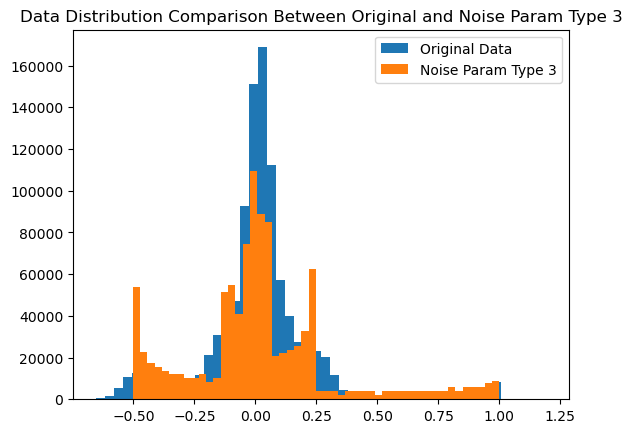

In [45]:
list_param = []
for i in range(0,50):
    list_param.append(np.exp(-0.2*i)*math.cos(0.2*4.4*i))    
list_param_mat = np.zeros([1000,1000])
for i in range(0,1000):
    for j in range(0,1000):
        noise_val = np.exp(-0.2*np.abs(j-i)/40)*math.cos(0.2*4.4*np.abs(j-i)/40)
        list_param_mat[i,j] = noise_val
        

plt.hist(data.flatten().numpy(), label="Original Data", bins=50)
plt.hist(list_param_mat.flatten(),label="Noise Param Type 3",bins=50)
plt.legend()
plt.title("Data Distribution Comparison Between Original and Noise Param Type 3")
plt.savefig("PRJ_AUTO_NOISEPARAM/results/fig2_data_dist_compare.png")
plt.show()

## Quantatively Compare Results aginst original covariance matrix and Noise Param Type 3

In [46]:
def KL(P,Q):
    epsilon = 0.00001
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

In [47]:
gen_img = data_smoothed.cpu().numpy().flatten()
gen_img = gen_img - min(gen_img)
gen_img = gen_img/gen_img.sum()

org_img = data.flatten().numpy()
org_img = org_img - min(org_img)
org_img = org_img/org_img.sum()

print("KL Divergence Between Original Data and Diffusion Model",KL(gen_img, org_img))

KL Divergence Between Original Data and Diffusion Model 0.0010546260292323797


In [48]:
typ3_img = list_param_mat.flatten()
typ3_img = typ3_img - min(typ3_img)
typ3_img = typ3_img/typ3_img.sum()

org_img = data.flatten().numpy()
org_img = org_img - min(org_img)
org_img = org_img/org_img.sum()

print("KL Divergence Between Original Data and Diffusion Model",KL(typ3_img, org_img))

KL Divergence Between Original Data and Diffusion Model 0.015967479925054272
